# Description

This notebook is a tutorial on how to use Tensorflow for time series data.

In [12]:
# Install required libs on the fly.
# Tensorflow needs to be downloaded from pip as poetry relies on the package metadata to resolve packages, 
# tensorflow does not consistently contain the required metadata. https://github.com/python-poetry/poetry/issues/8764
!sudo /bin/bash -c "(source /venv/bin/activate; pip install tensorflow)"
!sudo /bin/bash -c "(source /venv/bin/activate; pip install tensorflow-probability)"
!sudo /bin/bash -c "(source /venv/bin/activate; pip install tf-keras)"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00a 0:00:01


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [166]:
import logging
import collections
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.plotting as pdp
import seaborn as sns
import scipy.stats as stats
import sklearn.metrics as metrics
import tensorflow as tf
import tf_keras
import tensorflow_probability as tfp


import helpers.hprint as hprint
import helpers.hdbg as hdbg
import helpers.hpandas as hpanda

In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8ef47a07-a430-40a1-bdaf-daa3a3c769c9.json'


# Config

In [119]:
config = {
    # Train/test split.
    "train_start_date": "2020-01-01",
    "train_end_date": "2023-12-31",
    "test_start_date": "2024-01-01",
    "test_end_date": "2024-12-31",
    "data": {
        # Linear trend params.
        "slope": 0.005,
        "intercept": 15,
        # Fourier term params for seasonality component.
        "weekly_amp_sin": 5.0,
        "weekly_amp_cos": 2.5,
        # List of holidays and their impact.
        "holidays_dates": ['2020-12-25', '2021-12-25', '2022-12-25', "2023-12-25", "2024-12-25"],
        "holidays_impact": 2.5,
        # Autoregression params.
        "ar_order": 1,
        "phi": 0.7,
        # Noise std.
        "seed": 42,
        "noise_sigma": 2.0,
    },
    "model": {
       "learning_rate": 0.1,
        "num_steps": 200,
    },
}
print(config)

{'train_start_date': '2020-01-01', 'train_end_date': '2023-12-31', 'test_start_date': '2024-01-01', 'test_end_date': '2024-12-31', 'data': {'slope': 0.005, 'intercept': 15, 'weekly_amp_sin': 5.0, 'weekly_amp_cos': 2.5, 'holidays_dates': ['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25'], 'holidays_impact': 2.5, 'ar_order': 1, 'phi': 0.7, 'seed': 42, 'noise_sigma': 2.0}, 'model': {'learning_rate': 0.1, 'num_steps': 200}}


# Generate data

In [16]:
# Generate date range.
dates = pd.date_range(start=config["train_start_date"], end=config["test_end_date"], freq='D')
time = np.arange(len(dates))
# Define linear trend.
y_trend = config["data"]["slope"] * time + config["data"]["intercept"]
# Define the seasonality factor.
p_weekly = 7
y_weekly_seasonality = config["data"]["weekly_amp_sin"] * np.sin(2 * np.pi * time / p_weekly) + config["data"]["weekly_amp_cos"] * np.cos(2 * np.pi * time / p_weekly)
# Define holidays impact.
holiday_effect = np.zeros(len(dates))
holiday_effect[np.isin(dates.date, pd.to_datetime(config["data"]["holidays_dates"]).date)] = config["data"]["holidays_impact"]
# Define white noise.
np.random.seed(config["data"]["seed"])
noise = np.random.normal(loc=0, scale=config["data"]["noise_sigma"], size=len(time))
# Add autoregressive behavior.
y = np.zeros(len(time))
y[0] = y_trend[0] + y_weekly_seasonality[0] + holiday_effect[0] + noise[0]
for i in range(1, len(time)):
    y[i] = config["data"]["phi"] * y[i-1] + y_trend[i] + y_weekly_seasonality[i] + holiday_effect[i] + noise[i]
df = pd.DataFrame({"ds": dates, "y": y})
# Add lagged value of the target as a feature.
df["y.lag1"] = df["y"].shift(1)
# The first row is NaN -> drop it.
df = df.dropna()
_LOG.info(hpanda.df_to_str(df, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1824,2024-12-29 00:00:00,78.387492,83.360033
1825,2024-12-30 00:00:00,74.449184,78.387492
1826,2024-12-31 00:00:00,71.713198,74.449184


INFO  None


<Axes: title={'center': 'Original data'}, xlabel='Time', ylabel='Target variable'>

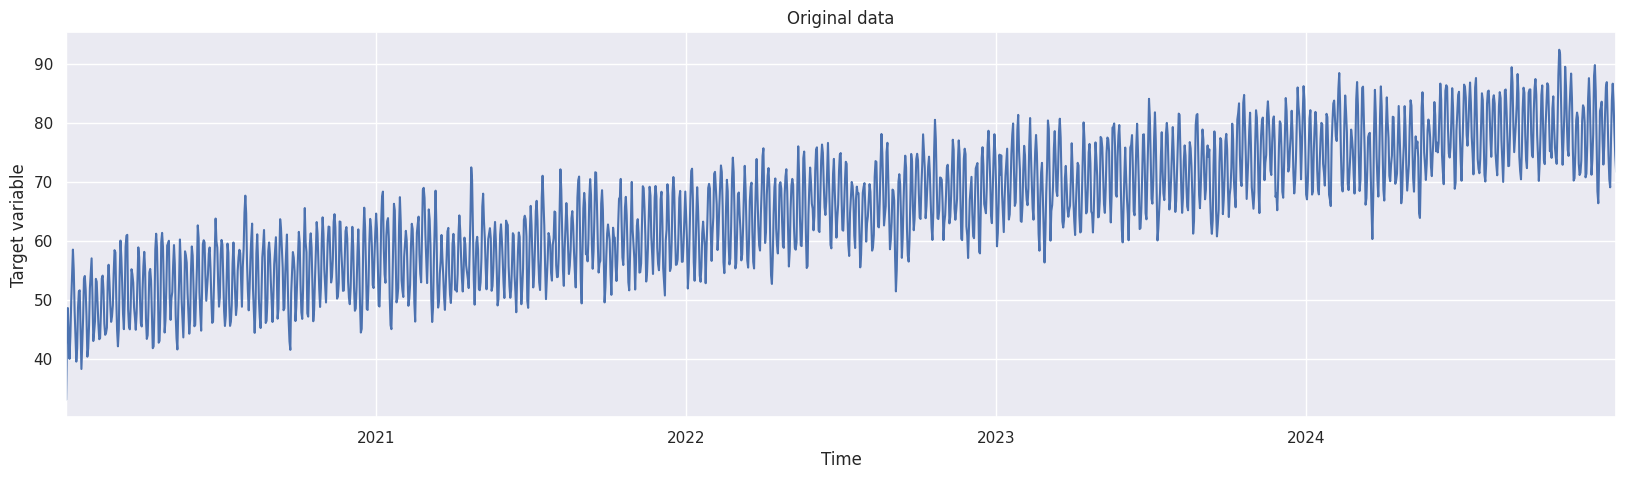

In [17]:
df.set_index("ds")["y"].plot(title="Original data", ylabel="Target variable", xlabel="Time")

## Plotting Helpers

In [24]:
pdp.register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [132]:
def plot_forecast(
    x: np.ndarray,
    y: np.ndarray,
    forecast_mean: np.ndarray,
    forecast_scale: np.ndarray,
    forecast_samples: np.ndarray,
    title: str,
    x_locator: Optional[plt.Locator] = None,
    x_formatter: Optional[plt.Formatter] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a forecast distribution against the 'true' time series.

    :param x: The time points for the entire dataset.
    :param y: The ground truth values for the time series.
    :param forecast_mean: The mean values of the forecasted distribution.
    :param forecast_scale: The scale (standard deviation) of the forecasted distribution.
    :param forecast_samples: Samples drawn from the forecasted distribution.
    :param title: The title of the plot.
    :param x_locator: Optional locator for the x-axis (e.g., for dates).
    :param x_formatter: Optional formatter for the x-axis labels.
    :return: A tuple containing the figure and axes objects of the plot.
    """
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    #
    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    #
    ax.plot(x, y, lw=2, color=c1, label="ground truth")
    forecast_steps = x[num_steps_train : num_steps_train + num_steps_forecast]
    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)
    ax.plot(
        forecast_steps,
        forecast_mean,
        lw=2,
        ls="--",
        color=c2,
        label="forecast",
    )
    ax.fill_between(
        forecast_steps,
        forecast_mean - 2 * forecast_scale,
        forecast_mean + 2 * forecast_scale,
        color=c2,
        alpha=0.2,
    )
    ymin, ymax = (
        min(np.min(forecast_samples), np.min(y)),
        max(np.max(forecast_samples), np.max(y)),
    )
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange * 0.1, ymax + yrange * 0.1])
    ax.set_title("{}".format(title))
    ax.legend()
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    return fig, ax


In [133]:
def plot_components(
    dates: np.ndarray,
    component_means_dict: Dict[str, np.ndarray],
    component_stddevs_dict: Dict[str, np.ndarray],
    *,
    x_locator: Optional[plt.Locator] = None,
    x_formatter: Optional[plt.Formatter] = None,
) -> Tuple[plt.Figure, Dict[str, plt.Axes]]:
    """
    Plot the contributions of posterior components in a single figure.

    :param dates: Array of dates corresponding to the time series.
    :param component_means_dict: Dictionary where keys are component names 
        and values are arrays of mean contributions of each component.
    :param component_stddevs_dict: Dictionary where keys are component names 
        and values are arrays of standard deviations of each component.
    :param x_locator: Optional locator for the x-axis (e.g., for dates).
    :param x_formatter: Optional formatter for the x-axis labels.
    :return: A tuple containing the figure and an ordered dictionary of axes objects, 
        keyed by component names.
    """
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    #
    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    #
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(
            dates,
            component_mean - 2 * component_stddev,
            component_mean + 2 * component_stddev,
            color=c2,
            alpha=0.5,
        )
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    #
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict


In [138]:
def plot_one_step_predictive(
    dates: np.ndarray,
    observed_time_series: np.ndarray,
    one_step_mean: np.ndarray,
    one_step_scale: np.ndarray,
    *,
    x_locator: Optional[plt.Locator] = None,
    x_formatter: Optional[plt.Formatter] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a time series against a model's one-step predictions.

    :param dates: Array of dates corresponding to the time series.
    :param observed_time_series: Array of observed values in the time series.
    :param one_step_mean: Array of one-step-ahead predicted mean values.
    :param one_step_scale: Array of one-step-ahead predicted scale (standard deviation).
    :param x_locator: Optional locator for the x-axis (e.g., for dates).
    :param x_formatter: Optional formatter for the x-axis labels.
    :return: A tuple containing the figure and axes objects of the plot.
    """
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    #
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(
        dates,
        one_step_mean - one_step_scale,
        one_step_mean + one_step_scale,
        alpha=0.1,
        color=c2,
    )
    ax.legend()
    #
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax


## Tran and Test Split

In [139]:
start_date_filter = df["ds"] >= config["train_start_date"]
end_date_filter = df["ds"] <= config["train_end_date"]
df_train = df[start_date_filter & end_date_filter]
_LOG.info(hpanda.df_to_str(df_train, log_level=logging.INFO))

start_date_filter = df["ds"] >= config["test_start_date"]
end_date_filter = df["ds"] <= config["test_end_date"]
df_test = df[start_date_filter & end_date_filter].reset_index(drop=True)
_LOG.info(hpanda.df_to_str(df_test, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1458,2023-12-29 00:00:00,86.189145,81.430431
1459,2023-12-30 00:00:00,83.89076,86.189145
1460,2023-12-31 00:00:00,76.324779,83.89076


INFO  None


,ds,y,y.lag1
0,2024-01-01 00:00:00,67.852807,76.324779
1,2024-01-02 00:00:00,67.038486,67.852807
2,2024-01-03 00:00:00,70.040899,67.038486
,...,...,...
363,2024-12-29 00:00:00,78.387492,83.360033
364,2024-12-30 00:00:00,74.449184,78.387492
365,2024-12-31 00:00:00,71.713198,74.449184


INFO  None


## Model and Fitting

In [140]:
def build_model(observed_time_series: np.ndarray) -> tfp.sts.Sum:
    """
    Build a Structural Time Series (STS) model for forecasting.

    The model includes the following components:
    - A local linear trend to capture long-term changes.
    - A seasonal component to account for day-of-week effects.
    - An autoregressive component to model temporal dependencies.

    :param observed_time_series: The observed time series data as a NumPy array.
    :return: An STS model combining trend, seasonal, and autoregressive components.
    """
    trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)
    day_of_week_effect = tfp.sts.Seasonal(
        num_seasons=7,
        num_steps_per_season=1,
        observed_time_series=observed_time_series,
        name="day_of_week_effect",
    )
    autoregressive = tfp.sts.Autoregressive(
        order=1,
        observed_time_series=observed_time_series,
        name="autoregressive",
    )
    # Combine components into a single model
    model = tfp.sts.Sum(
        [trend, day_of_week_effect, autoregressive],
        observed_time_series=observed_time_series,
    )
    return model
     

In [141]:
model = build_model(df_train["y"].to_numpy())

## Background

This code is part of a **Variational Inference** (VI) process used to approximate the posterior distribution of a Bayesian model. In this case, TensorFlow Probability (TFP) is used to build a **surrogate posterior** and optimize it to approximate the true posterior distribution of a model. The idea behind variational inference is to turn the problem of calculating intractable posteriors into a tractable optimization problem. This is done by approximating the true posterior with a simpler distribution (the surrogate posterior) and then optimizing it to be as close as possible to the true posterior.

#### Key Concepts and When to Use

- **Bayesian Inference**: In Bayesian inference, we aim to calculate the posterior distribution of the model parameters given the data. This can be computationally expensive or intractable for complex models.
- **Variational Inference (VI)**: VI is a method to approximate the posterior distribution by optimizing a surrogate distribution (which is easier to compute). It does this by minimizing the **Evidence Lower Bound (ELBO)**, which is a measure of how close the surrogate posterior is to the true posterior.
  
**Optimizing the Variational Loss Function (ELBO):**

```python
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(
        observed_time_series=df_train["y"].to_numpy()).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf_keras.optimizers.Adam(learning_rate=config["model"]["learning_rate"]),
    num_steps=num_variational_steps,
    jit_compile=True)
```

- **Purpose**: This performs the optimization of the variational posterior by minimizing the **ELBO loss**.
- **How it works**: 
  - `target_log_prob_fn`: This is the log-probability of the model’s joint distribution, evaluated on the observed data.
  - `surrogate_posterior`: This is the surrogate posterior distribution (`qs`), which we aim to optimize.
  - `optimizer`: The optimizer used to minimize the ELBO loss. Here, Adam is used with a learning rate specified in the config.
  - `num_steps`: The number of optimization steps, controlled by `num_variational_steps`.
  - `jit_compile`: This enables JIT (Just-In-Time) compilation to speed up the optimization process using TensorFlow's XLA (Accelerated Linear Algebra).
- **When to use**: This is the core part of variational inference, used when we want to approximate the posterior distribution in a computationally efficient way. It’s helpful for models where traditional sampling-based approaches (e.g., MCMC) are too slow or impractical.

### Model Parameters

The model consists of various components, and the parameters pertain to these components. Let’s go over some typical model parameters in a **Structural Time Series** (STS) model and their role:

1. **Trend Parameters**:
   - These represent the long-term movements in the time series.
   - Common parameters:
     - **Level**: The current level of the time series.
     - **Slope**: The rate of change of the level over time.

2. **Seasonal Components**:
   - These capture periodic patterns, such as weekly or yearly cycles.
   - Common parameters:
     - **Amplitude**: The strength of the seasonal effect.
     - **Period**: The length of the season (e.g., 7 for weekly seasonality).
   
3. **Autoregressive Parameters**:
   - These capture dependencies between time steps.
   - Common parameters:
     - **Order**: The number of past time steps considered in the autoregressive process (e.g., AR(1) for one-step lag).
     - **Coefficient**: The weight of the past time step in predicting the current value.

4. **Noise Parameters**:
   - These represent the random fluctuations or errors in the data.
   - Common parameters:
     - **Observation Noise Scale**: The variance of the observation noise.
   

In [116]:
# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

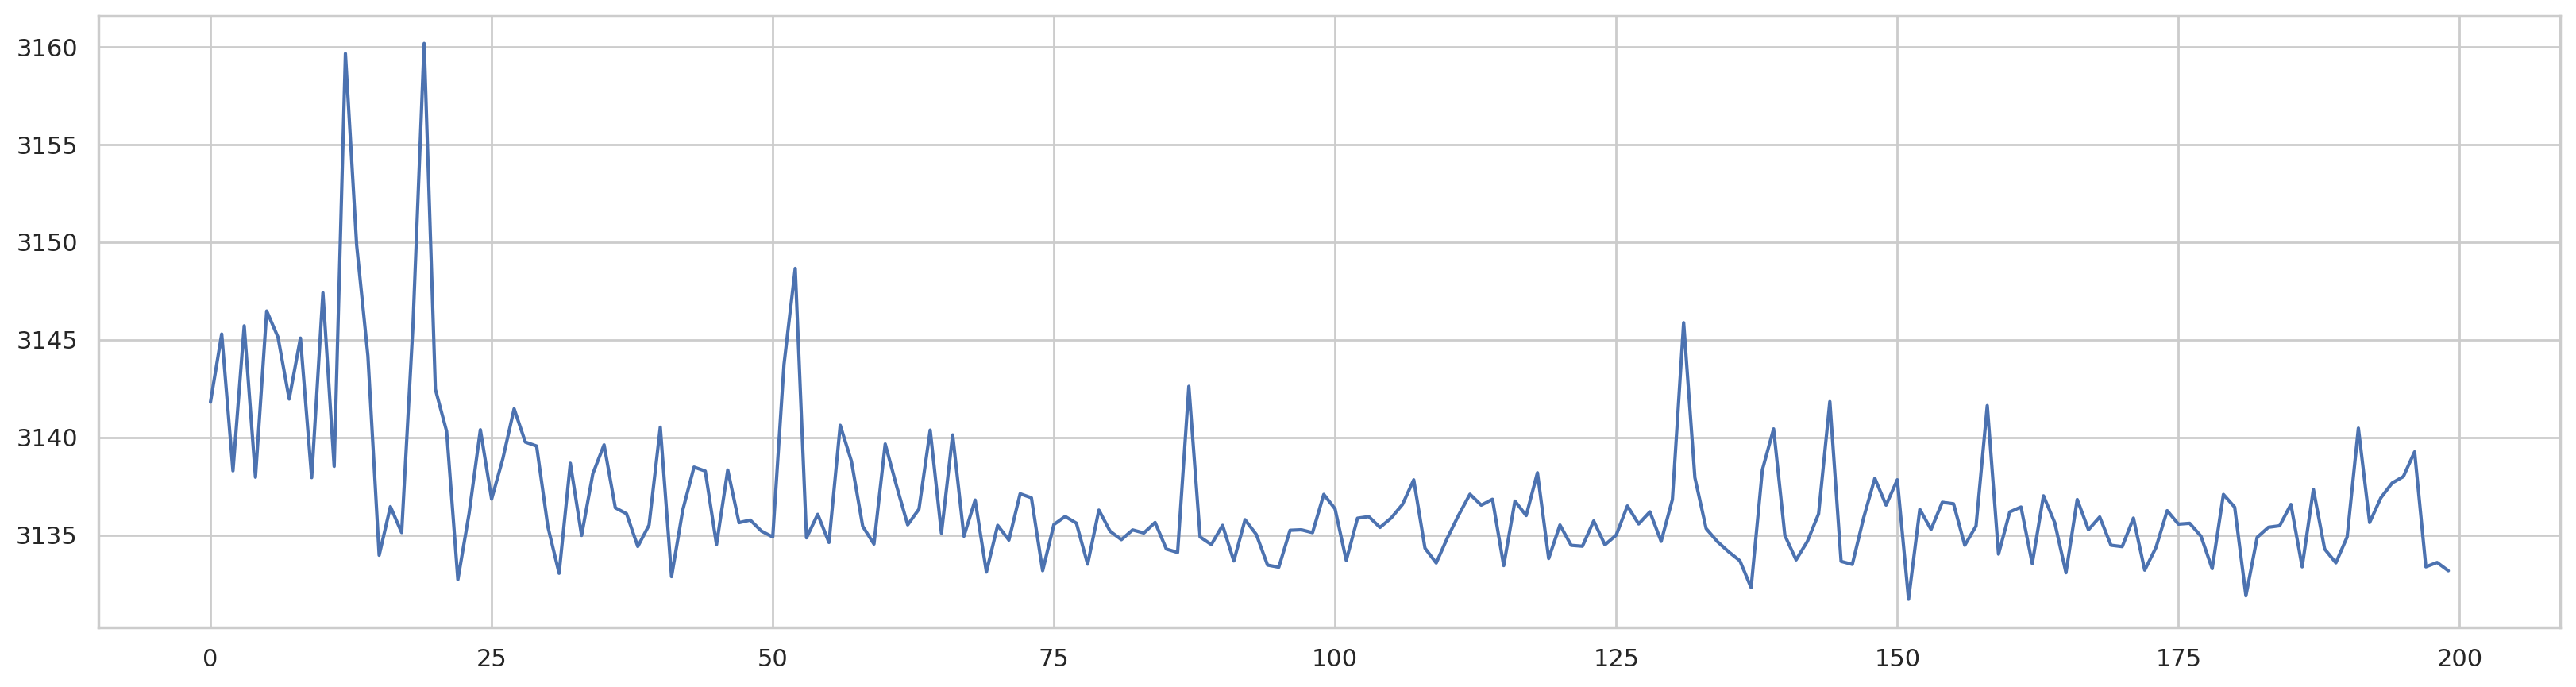

In [147]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = config["model"]["num_steps"]

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(
        observed_time_series=df_train["y"].to_numpy()).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf_keras.optimizers.Adam(learning_rate=config["model"]["learning_rate"]),
    num_steps=num_variational_steps,
    jit_compile=True)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_ = variational_posteriors.sample(50)

In [148]:
_LOG.info("Inferred parameters:")
for param in model.parameters:
  _LOG.info("%s: %s +- %s", param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0))

INFO  Inferred parameters:
INFO  observation_noise_scale: 0.2581900746176054 +- 0.10447707072807008
INFO  LocalLinearTrend/_level_scale: 0.07812254619419981 +- 0.028432856912874588
INFO  LocalLinearTrend/_slope_scale: 0.001811630911671026 +- 0.0009076347485154851
INFO  day_of_week_effect/_drift_scale: 0.017233926029598813 +- 0.012007880394518257
INFO  autoregressive/_coefficients: [0.69971009] +- [0.01375116]
INFO  autoregressive/_level_scale: 1.8679227409067614 +- 0.037951533288657684


In [149]:
# Forecast the prediction.
forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=df_train["y"].to_numpy(),
    parameter_samples=q_samples_demand_,
    num_steps_forecast=len(df_test))
     

In [150]:
num_samples=10
(
    forecast_mean,
    forecast_scale,
    forecast_samples
) = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0],
    forecast_dist.sample(num_samples).numpy()[..., 0]
    )

WARNING 6 out of the last 6 calls to <bound method Distribution.sample of <tfp.distributions.AdditiveStateSpaceModel 'AdditiveStateSpaceModel' batch_shape=[50] event_shape=[366, 1] dtype=float64>> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


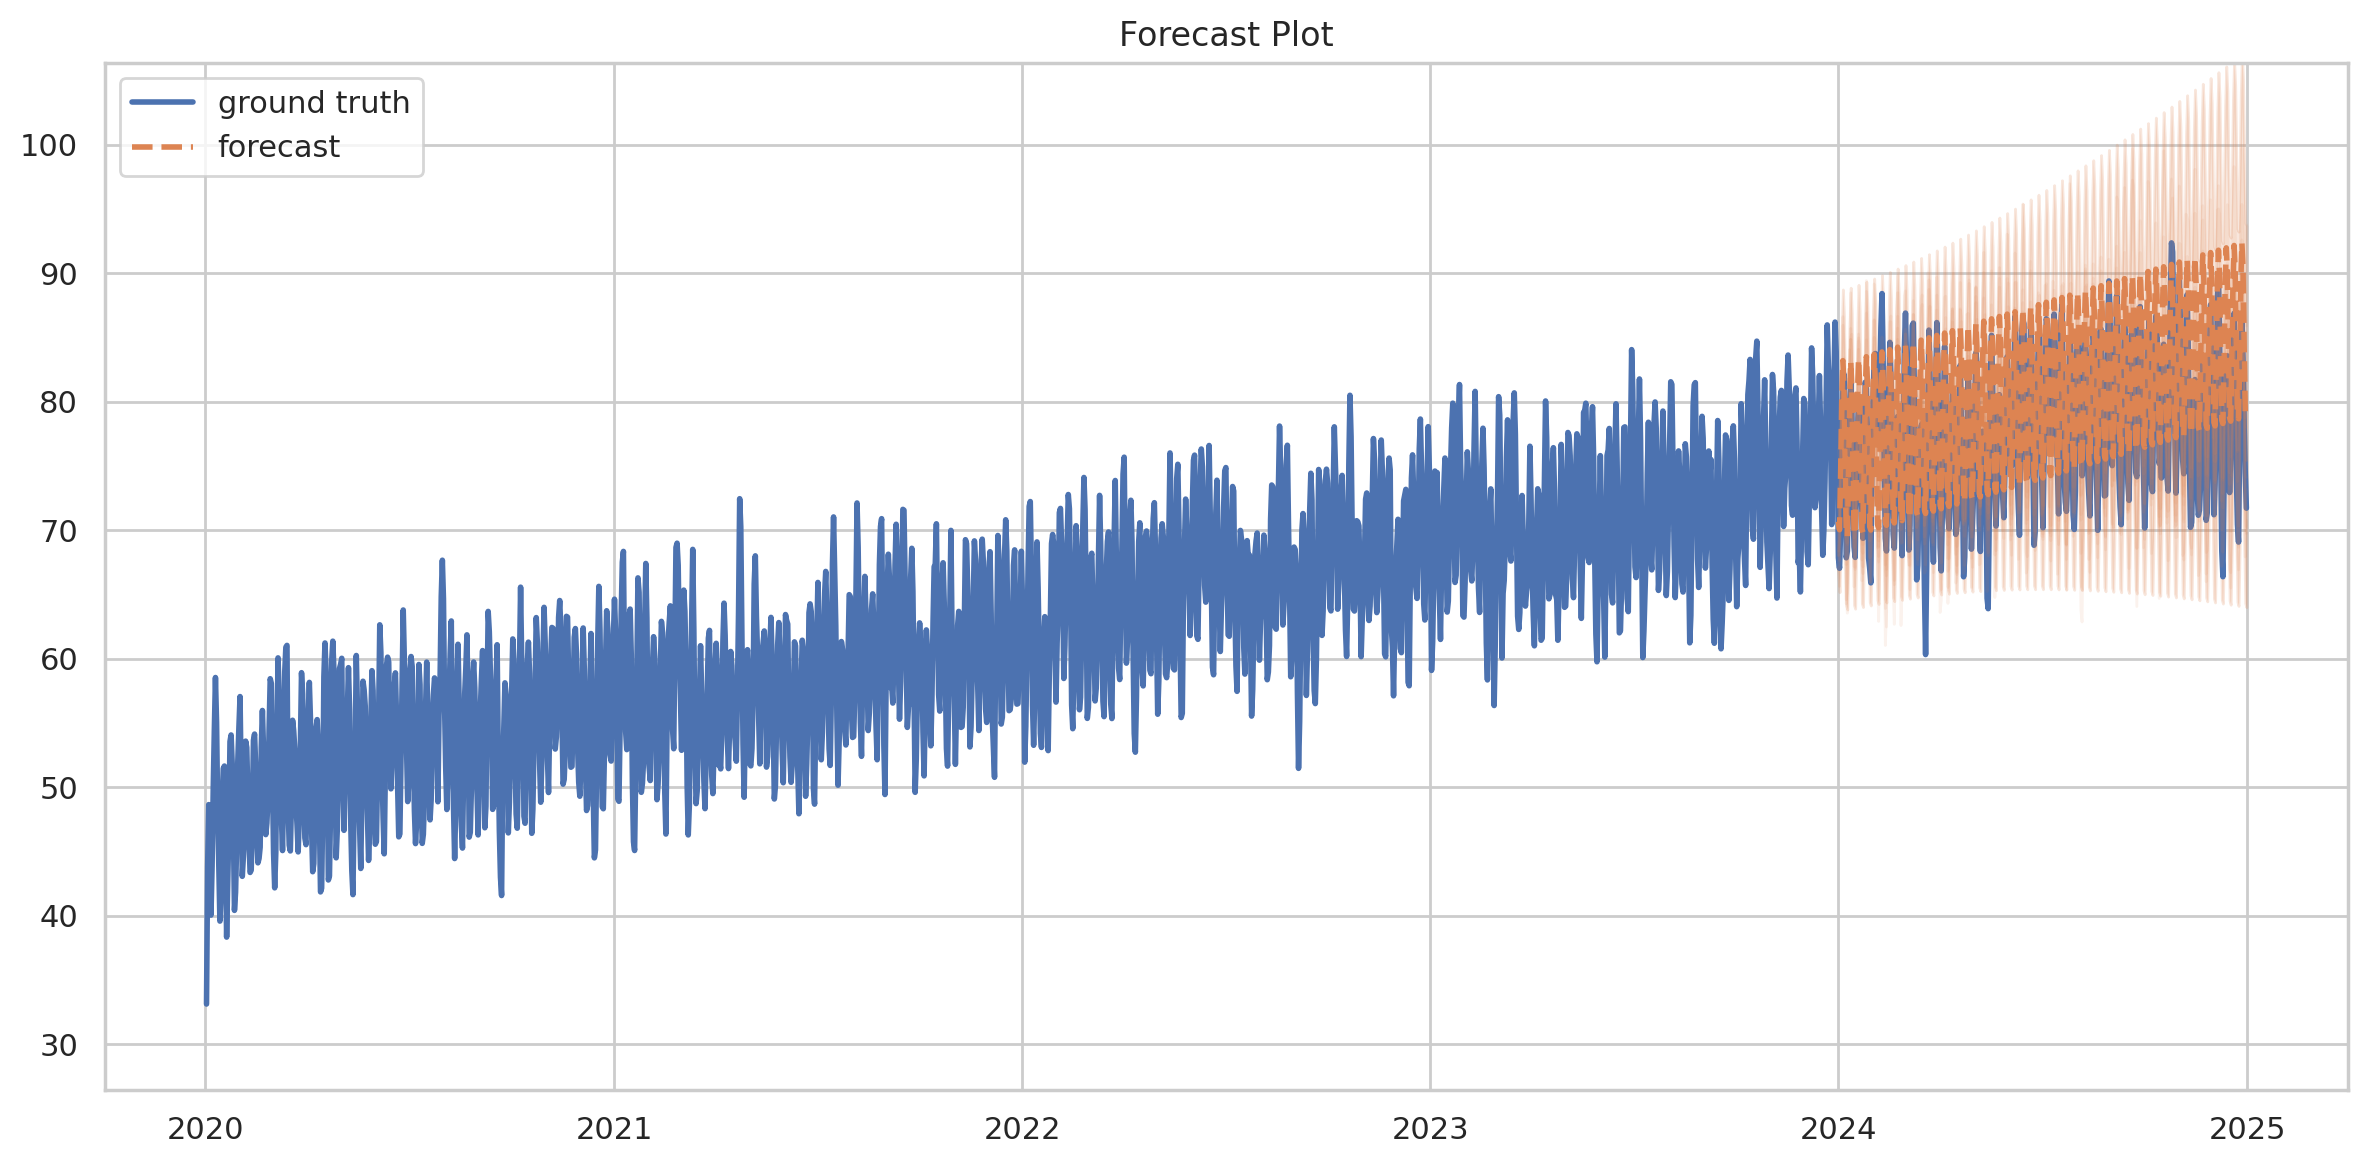

In [104]:
fig, ax = plot_forecast(df["ds"], df["y"].to_numpy(),
                        forecast_mean,
                        forecast_scale,
                        forecast_samples,
                        title="Forecast Plot",
                        x_locator=None, x_formatter=None)
fig.tight_layout()

In [163]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = tfp.sts.decompose_by_component(
    model,
    observed_time_series=df_test["y"].to_numpy(),
    parameter_samples=q_samples_)

WARNING 6 out of the last 6 calls to <bound method LinearGaussianStateSpaceModel.posterior_marginals of <tfp.distributions.AdditiveStateSpaceModel 'AdditiveStateSpaceModel' batch_shape=[50] event_shape=[366, 1] dtype=float64>> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


In [164]:
co2_component_means_, co2_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

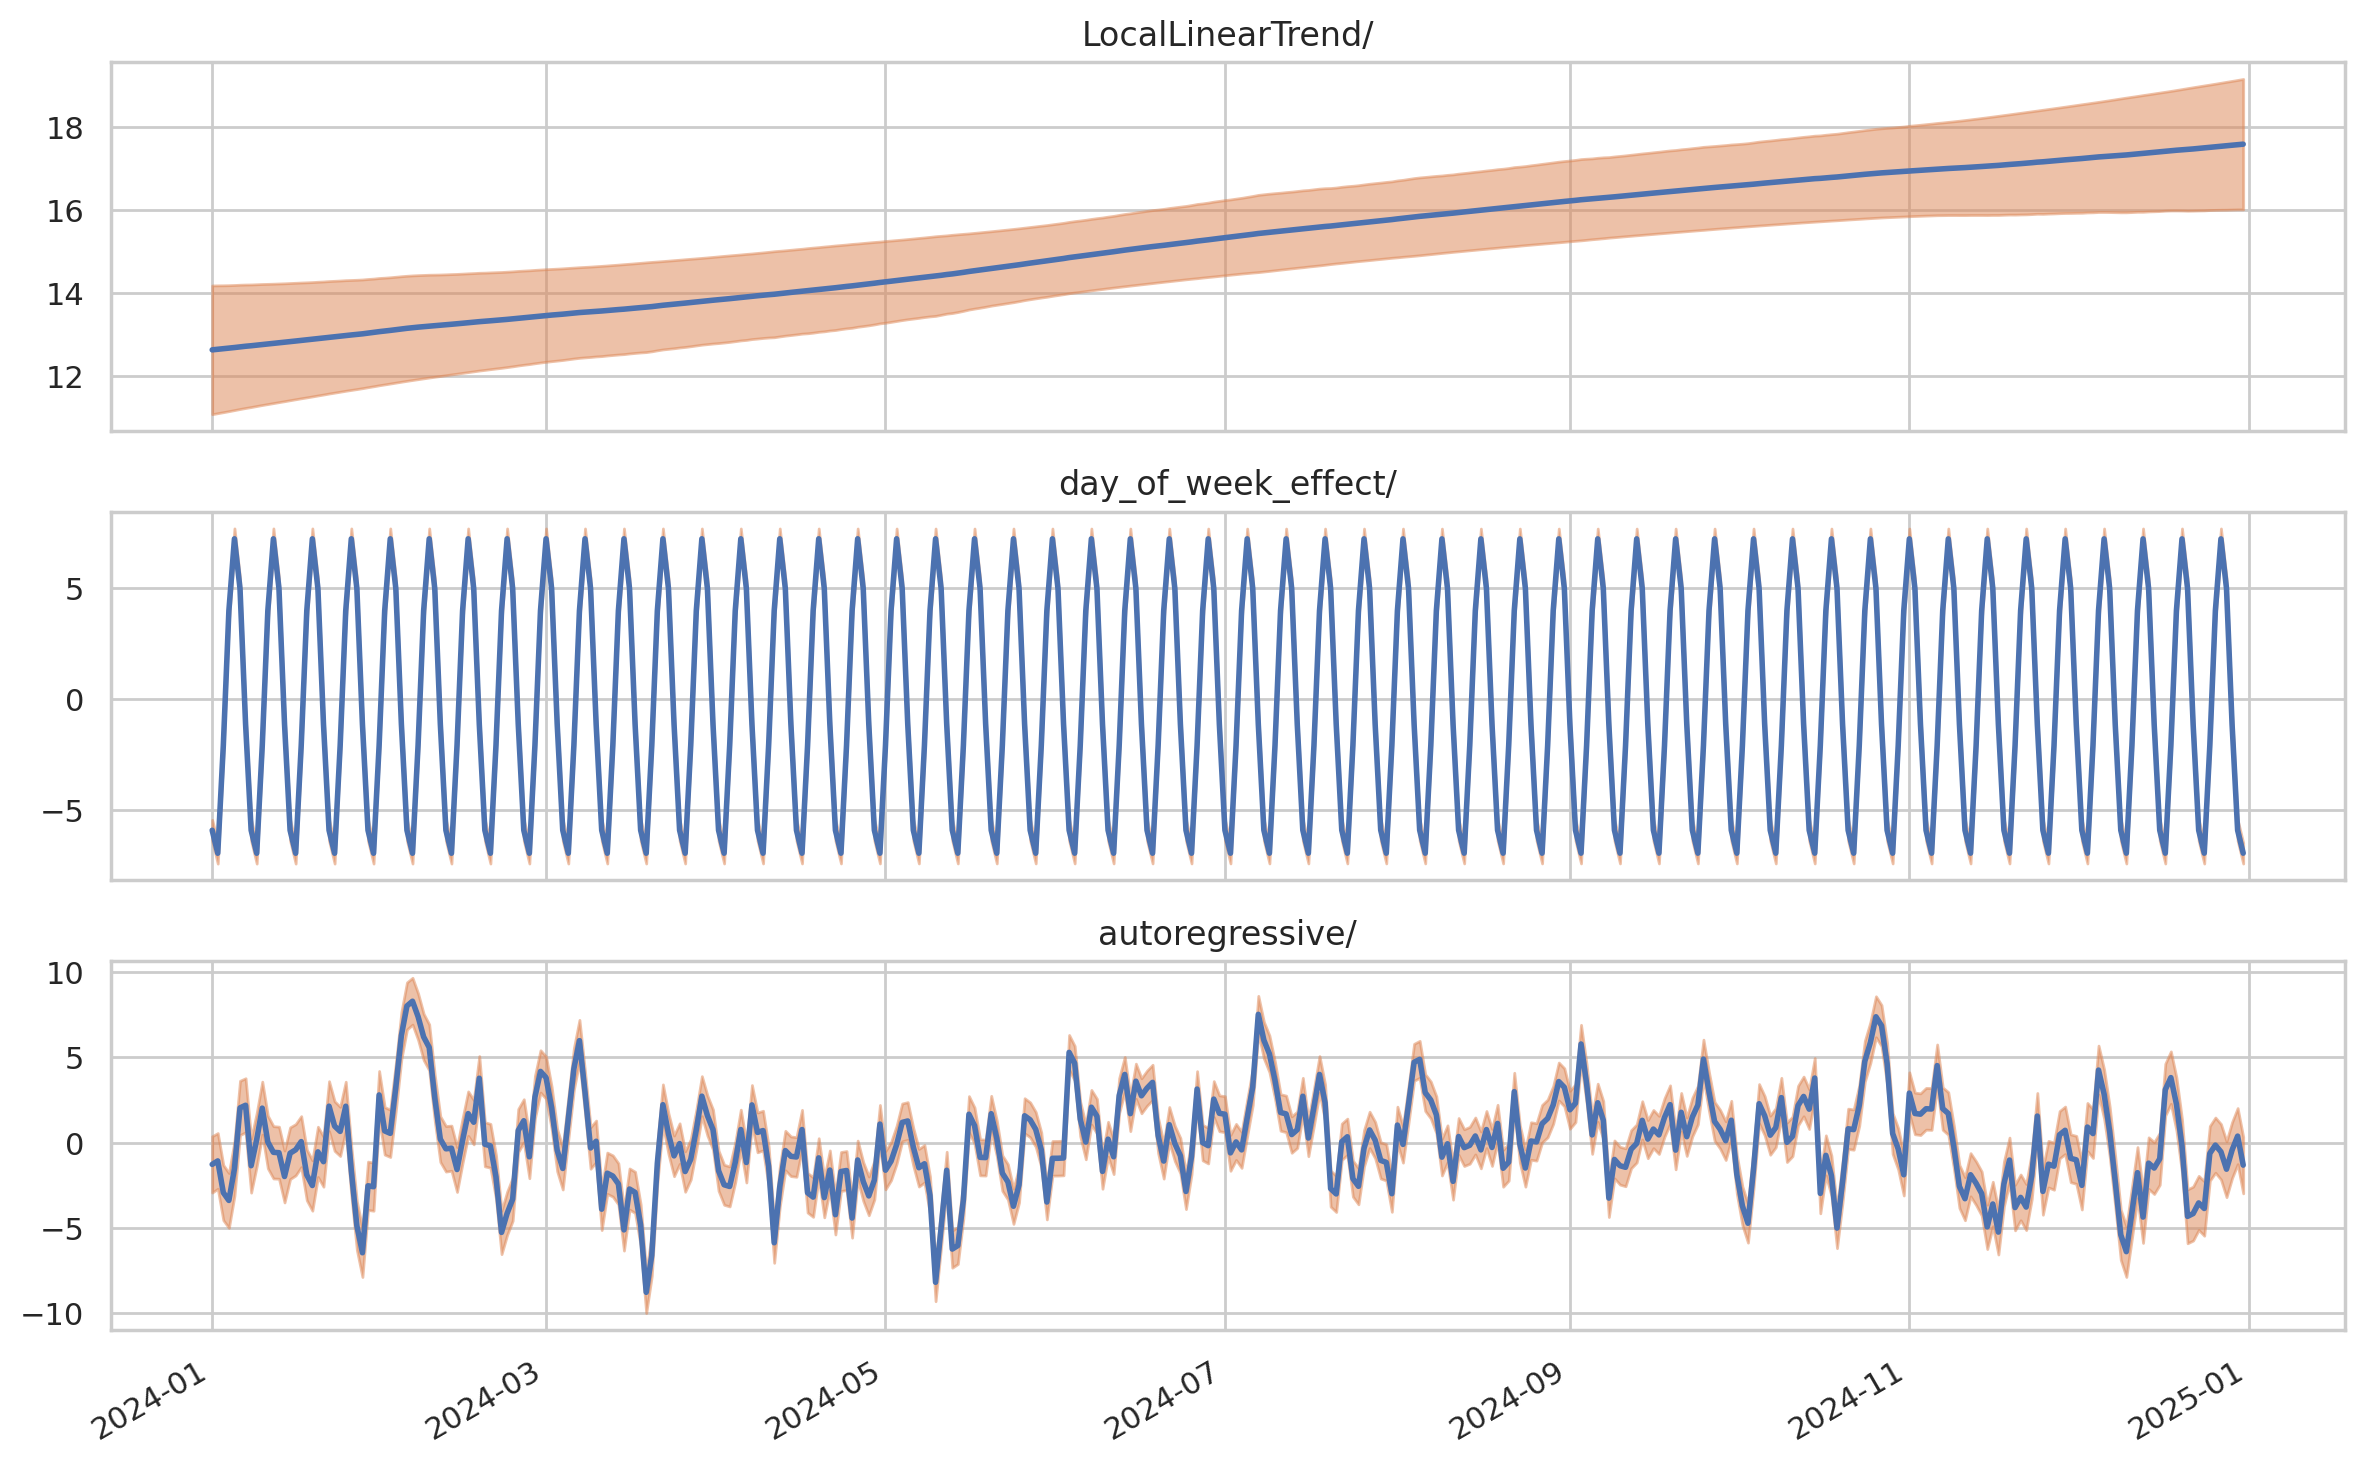

In [165]:
_ = plot_components(df_test["ds"], co2_component_means_, co2_component_stddevs_,
                    x_locator=None, x_formatter=None)

## Performance Metric

In [169]:
mae = metrics.mean_absolute_error(df_test["y"].to_numpy(), forecast_mean)
_LOG.info("Mean Absolute Error (MAE): %s", mae)
mse = metrics.mean_squared_error(df_test["y"].to_numpy(), forecast_mean)
_LOG.info("Mean Squared Error (MSE): %s", mse)

INFO  Mean Absolute Error (MAE): 5.751638542445379
INFO  Mean Squared Error (MSE): 43.40162209528987
